In [1]:
# RQA -- in between - raw quality assessment (amplitude * power frequency ratio * alpha band psd ratio)
# Extract file ---> collective data ---> Bad channel removal ----- Not needed [sampling rate correction (500Hz)] -----
# filtering (butterworth bandpass - tune coefficient)  ----- rereferencing ----- epoching ----- ERP ----- baseline removal ---- 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fftpack
import time
import mne
import matplotlib

## Reading the eeg data

In [3]:
channel_str='Channel 1:P8\
	Channel 2:T8\
	Channel 3:CP6\
	Channel 4:FC6\
	Channel 5:F8\
	Channel 6:F4\
	Channel 7:C4\
	Channel 8:P4\
	Channel 9:AF4\
	Channel 10:Fp2\
	Channel 11:Fp1\
	Channel 12:AF3\
	Channel 13:Fz\
	Channel 14:FC2\
	Channel 15:Cz\
	Channel 16:CP2\
	Channel 17:PO3\
	Channel 18:O1\
	Channel 19:Oz\
	Channel 20:O2\
	Channel 21:PO4\
	Channel 22:Pz\
	Channel 23:CP1\
	Channel 24:FC1\
	Channel 25:P3\
	Channel 26:C3\
	Channel 27:F3\
	Channel 28:F7\
	Channel 29:FC5\
	Channel 30:CP5\
	Channel 31:T7\
	Channel 32:P7'

string_channels = channel_str.replace('\t', ':').split(':')
channel_names = [string_channels[i] for i in range(len(string_channels)) if i % 2 != 0]
channel_names.append('ax')
channel_names.append('ay')
channel_names.append('az')
channel_names.append('trigger')
channel_names.append('timestamp(ms)')
all_channels = np.array(channel_names[:-5])

In [4]:
import pandas as pd

# TODO: Iteration
folder_path = 'E:/IITD/Depression-IITD/Depression-Sample-dataset-AIIMS/'
sham_or_active = 'Active/' 
patient = 'Preeti singh/'
pre_post_intervention = 'pre/'
directory = folder_path + sham_or_active + patient + pre_post_intervention
file_path = directory + '20230718202514_Preeti singh_22.08.23-01_GNG' + '.easy'
# OBSERVED: Active: pre all spike (AO/GNG/Eye close) ---- post except 17 and 25 all spike (AO/GNG/Eye close)
# OBSERVED: Sham: pre all spike in Eye close only ------ post reduced spikes in Eye close only

df = pd.read_csv(file_path, sep='\t')
df.columns=channel_names
df.head()

,P8,T8,CP6,FC6,F8,F4,C4,P4,AF4,Fp2,...,F7,FC5,CP5,T7,P7,ax,ay,az,trigger,timestamp(ms)
0,31399486,41813101,37317782,43707527,3615337,26556925,36763121,21657737,9144579,20491800,...,20403151,24447225,23063074,20909999,38154017,-490,-9865,-68,0,1689692114103
1,31407662,41821620,37328919,43716121,3626461,26563954,36772044,21666019,9151566,20499466,...,20413408,24458780,23074804,20922896,38166180,-107,-9747,225,0,1689692114105
2,31414594,41827732,37333736,43719642,3632327,26566235,36775766,21669698,9148165,20499951,...,20418334,24465610,23081071,20930846,38175052,-304,-9865,-29,0,1689692114107
3,31417887,41829310,37334285,43720062,3633515,26566595,36776069,21672006,9144064,20498742,...,20418375,24465020,23084448,20931321,38178422,-264,-9904,68,0,1689692114109
4,31422884,41828356,37333614,43717552,3630525,26564635,36775617,21674890,9146353,20502239,...,20418384,24464380,23088964,20932807,38181743,-411,-9708,-68,0,1689692114111


## MNE Analysis

In [5]:
transposed_data=df.T

# Create a MNE-Python info object and specifying sampling rate of data
ch_names = df.columns.tolist()[:-5]
ch_types = ['eeg' for i in range(32)]
info = mne.create_info(ch_names=ch_names,ch_types=ch_types, sfreq=500)

# Convert all EEG units to nV
raw = mne.io.RawArray(transposed_data.values[:-5,:]/1e9, info)

Creating RawArray with float64 data, n_channels=32, n_times=149999
    Range : 0 ... 149998 =      0.000 ...   299.996 secs
Ready.


In [6]:
# Printing information about the number of channels and the shape of the data
print(f"num of channels: {raw.info.get('nchan')}")
print(f'Shape of the data: {raw.get_data().shape}')
# To save all data in figures
# plt.switch_backend('TkAgg')

num of channels: 32
Shape of the data: (32, 149999)


### 1. Time amplitude plot

In [7]:
def time_amplitude(title):
    # Bandpass butterworth filter added
    # Cutoffs at 0.01, 45.00 Hz: -6.02, -6.02 dB
    # Applied only in currently plot
    fig = raw.plot(n_channels=32, 
    lowpass=45, 
    highpass=0.01,
    scalings={'eeg': 1e5} 
    )
    fig.savefig(f'MNE-graphs/time-amplitude/{title}-EEG.png')

    # In interactive plot, mark bad channels and they will be assigned to 'bads'
    print(raw.info)

### 2. Power spectral density plot

In [8]:
def psd(title):
    # To plot power spectral density plot
    fig = raw.compute_psd(fmax=150,picks=all_channels).plot(picks=all_channels, exclude="bads")
    fig.savefig(f'MNE-graphs/psd-frequency/{title}.png')

In [9]:
# Can plot graph before preprocessing
title = "0--Raw graph with line filter"
# time_amplitude(title)
# psd(title)

### Preprocessing

1. Bad channels removal

Interpolation required to estimate missing or bad channel values.

In [10]:
# raw.info['bads'] = # can set manually through interactive plot
# TODO: Code to automatically mark channels bad
raw = raw.interpolate_bads(reset_bads=False)
# title = "1--Bad channels removed"
# time_amplitude(title)
# psd(title)

C:\Users\vishw\AppData\Local\Temp\ipykernel_6932\2423377182.py:3: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw = raw.interpolate_bads(reset_bads=False)


2. Band pass filtering

In [11]:
# applied band pass filter of 0.01-45 Hz for depression detection 
raw.filter(0.01, 45, fir_design='firwin', picks=['eeg'])
title = "2--Band pass filtered graph"
# time_amplitude(title)
# psd(title)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 165001 samples (330.002 s)



C:\Users\vishw\AppData\Local\Temp\ipykernel_6932\3867887511.py:2: RuntimeWarning: filter_length (165001) is longer than the signal (149999), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.01, 45, fir_design='firwin', picks=['eeg'])
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


3. Rereferencing

Calculates the mean voltage from all electrodes at each time point and subtracts this mean from the voltage at each individual electrode.

In [12]:
raw.set_eeg_reference('average', projection=True).apply_proj() 
title = "3---Rereferenced"
# time_amplitude(title)
# psd(title)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


4. Deleting annotations - Not for first iteration


In [13]:
visual_inspection = pd.read_csv(directory + "Preeti singh_GoNogo_Test_2023_Jul_18_2026.csv")
events_from_annot, event_dict = mne.events_from_annotations(raw)

for i in range(visual_inspection.shape[0]):         
    result = np.where((mne.events_from_annotations(raw)[0][:,0] > visual_inspection['Response.started'][i]*500) & 
                      (mne.events_from_annotations(raw)[0][:,0] < visual_inspection['Response.stopped'][i]*500))
    raw.annotations.delete(result)

#### 5. Epoching

5.1 Adding trigger channel

In [14]:
# events_from_annot, event_dict = mne.events_from_annotations(raw)# Get events and event_id from an Annotations object.
trigger_col = df.values[:, -2]
trigger_times = []
event_id = {}
event_list = []

for i in range(len(trigger_col)):
    if trigger_col[i]!=0:
        trigger_times.append(i+2)
        event_id[str(trigger_col[i])] = trigger_col[i]
        event_list.append(trigger_col[i])

# Create an events array (trigger value, previous, sample number)
events = np.column_stack((trigger_times, np.zeros_like(trigger_times), event_list))

# Remove corrupted event
# From event_id
del event_id['3']

# From events
indexes=[]
for i in range(len(events)):
    if events[i][2] == 3:
        indexes.append(i)
events = np.delete(events, indexes, 0)

Using matplotlib as 2D backend.


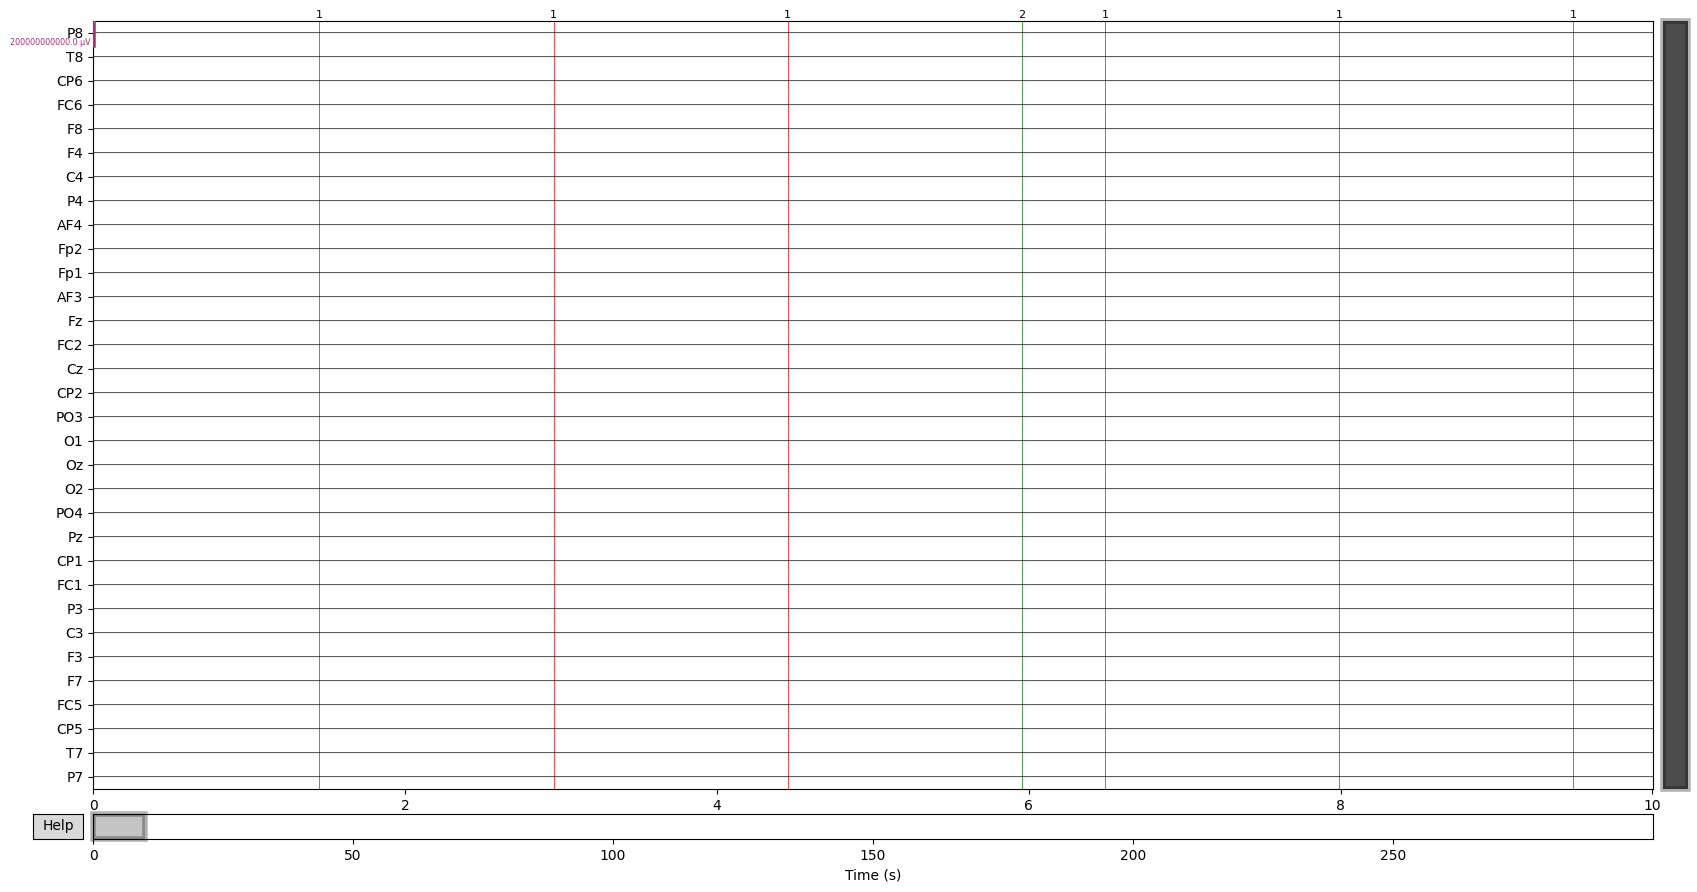

In [15]:
fig = raw.plot(n_channels=32, events=events, event_id=event_id, event_color={1:'r', 2:'g'}, scalings={'eeg': 1e5})
fig.savefig(f'MNE-graphs/time-amplitude/4---Trigger channels added.png')

5.2 Defining and segmenting Epochs

Not setting metadata
123 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 123 events and 401 original time points ...
0 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


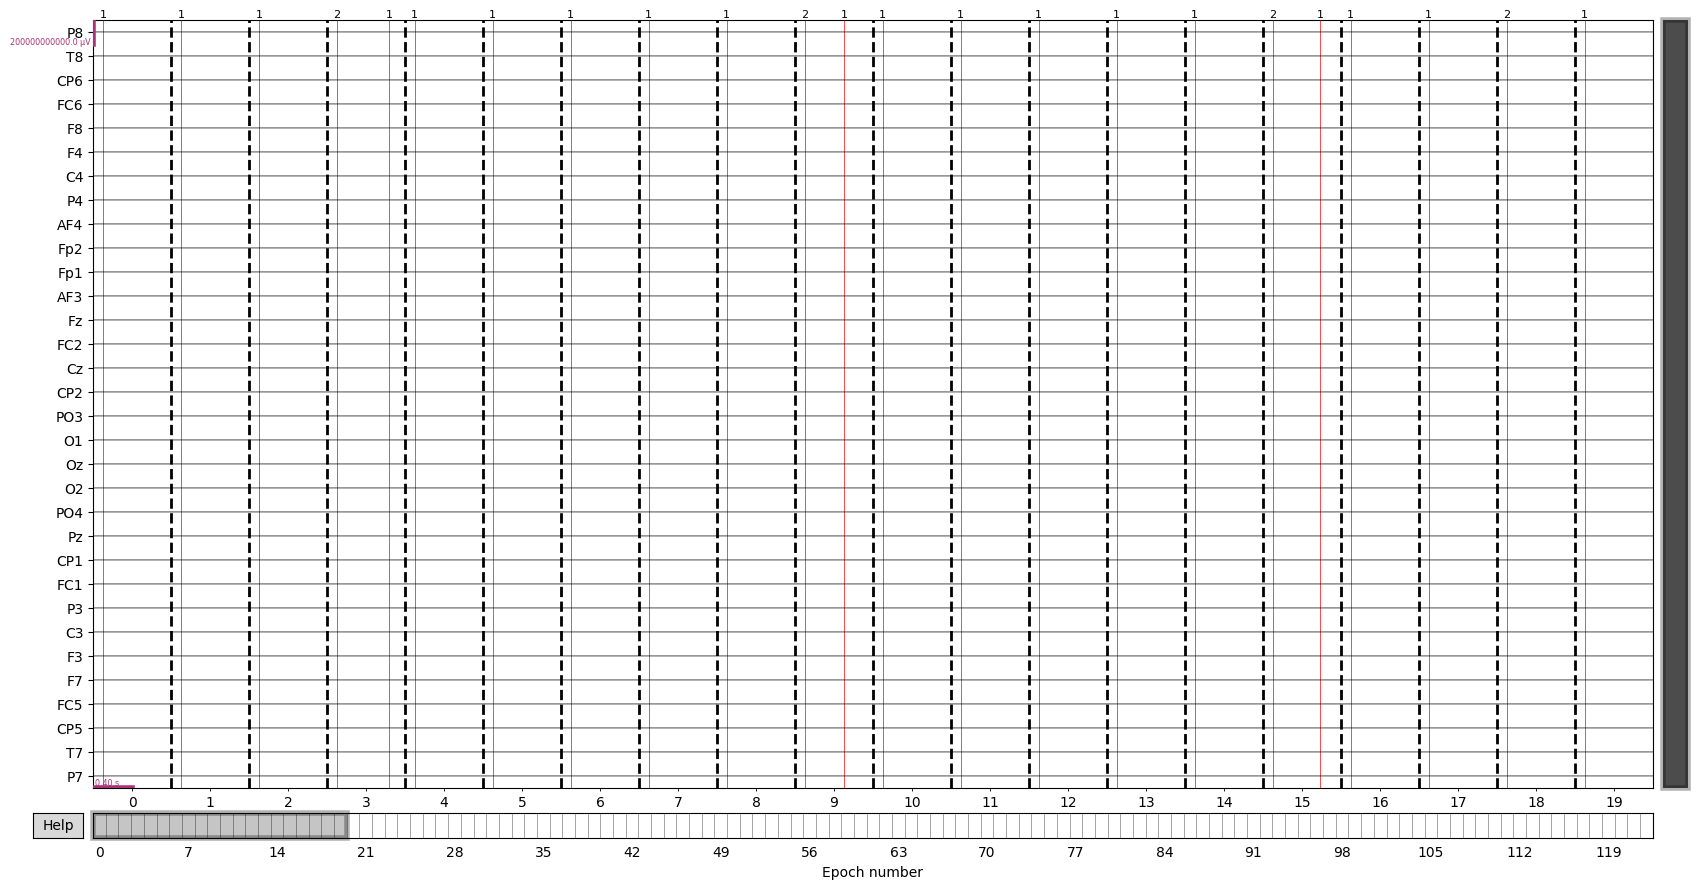

In [16]:
# Applying baseline correction (mode: mean) - baseline=(tmin, 0)
# Created an SSP operator (subspace dimension = 1)
tmin = -0.1
tmax = 0.7
# gonogo - 200 msec around stimulus

# reject_criteria = dict(eeg=100e-6) # Absolute Amplitude of each epoch should be smaller than 100 μV
# Add reject_criteria=reject_criteria in mne.Epochs
epochs = mne.Epochs(raw, events=events, event_id=None, tmin=tmin, tmax=tmax, baseline=(tmin, 0), detrend=1, preload=True,picks=['eeg'])
# List of 123 epochs, with 32 (number of channels) X 401 (epoch.times)
fig = epochs.plot(n_channels=32, scalings={'eeg': 1e5}, event_color={1:'r', 2:'g', 3:'b'}, events=events)
# fig.savefig(f'MNE-graphs/time-amplitude/5---Epochs added.png')

In [17]:
individual_nogo_epoch_plots = []
individual_go_epoch_plots = []
nogo = epochs['1'].average()
go = epochs['2'].average()
# discarded = epochs['3'].average()
evokeds = dict(go=go, nogo=nogo)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


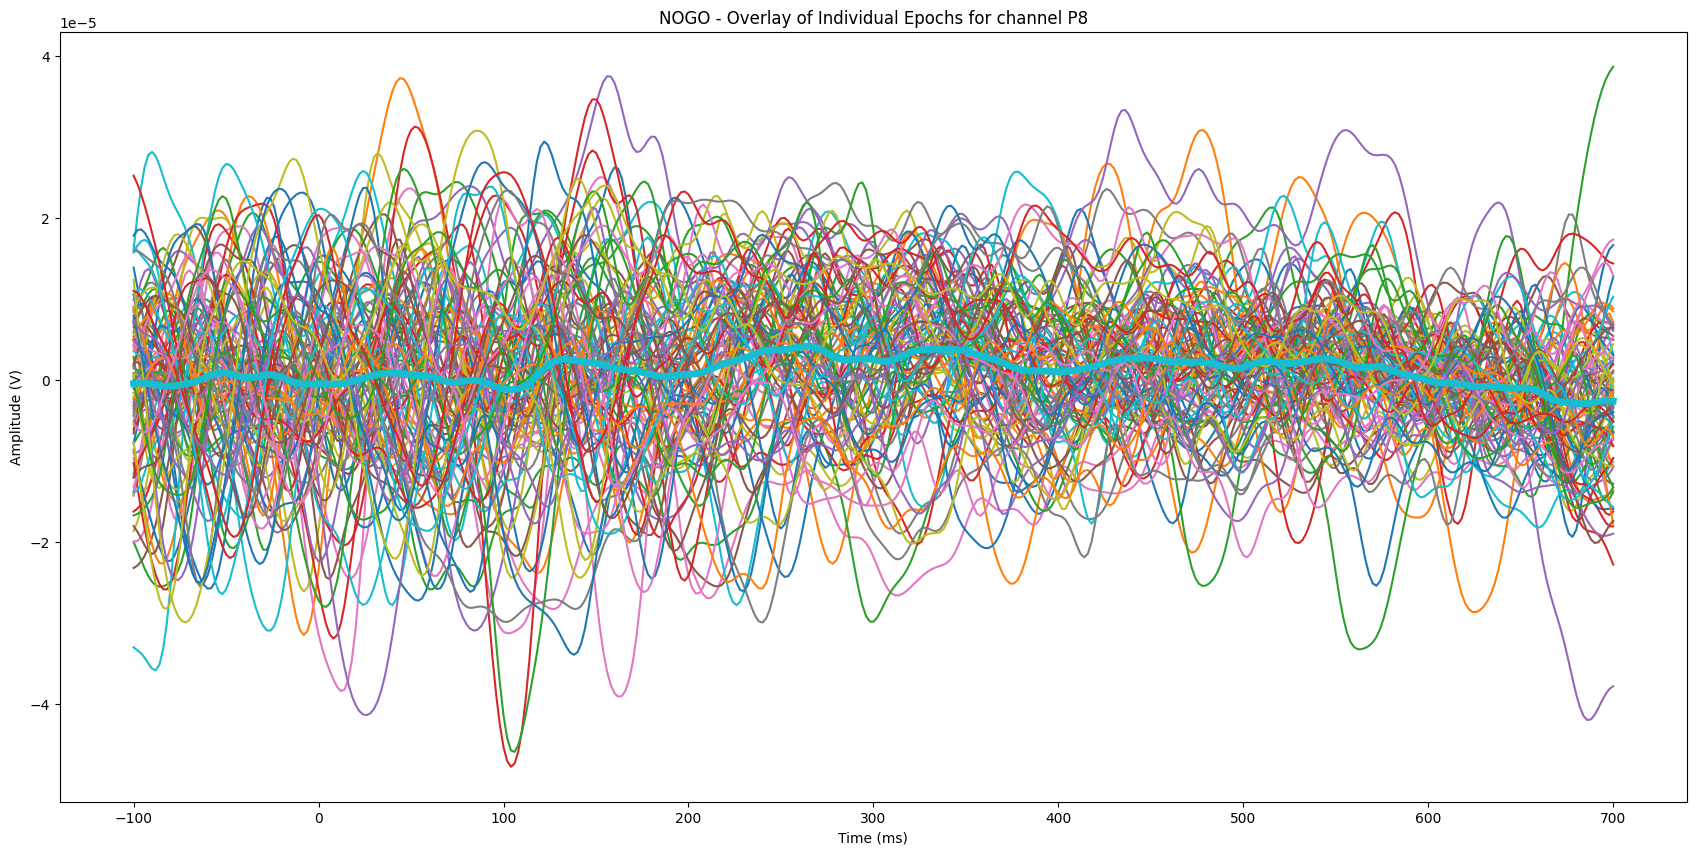

Need more than one channel to make topography for eeg. Disabling interactivity.


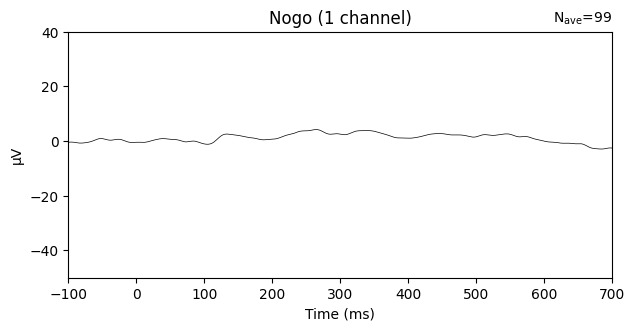

Need more than one channel to make topography for eeg. Disabling interactivity.


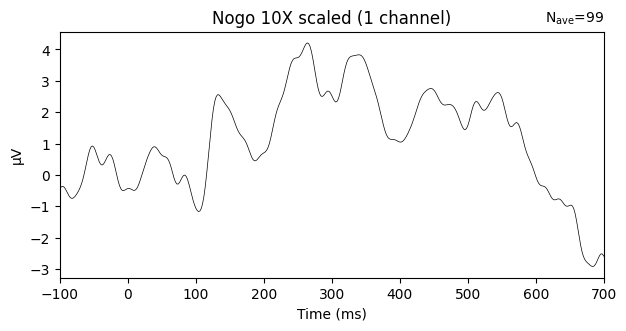

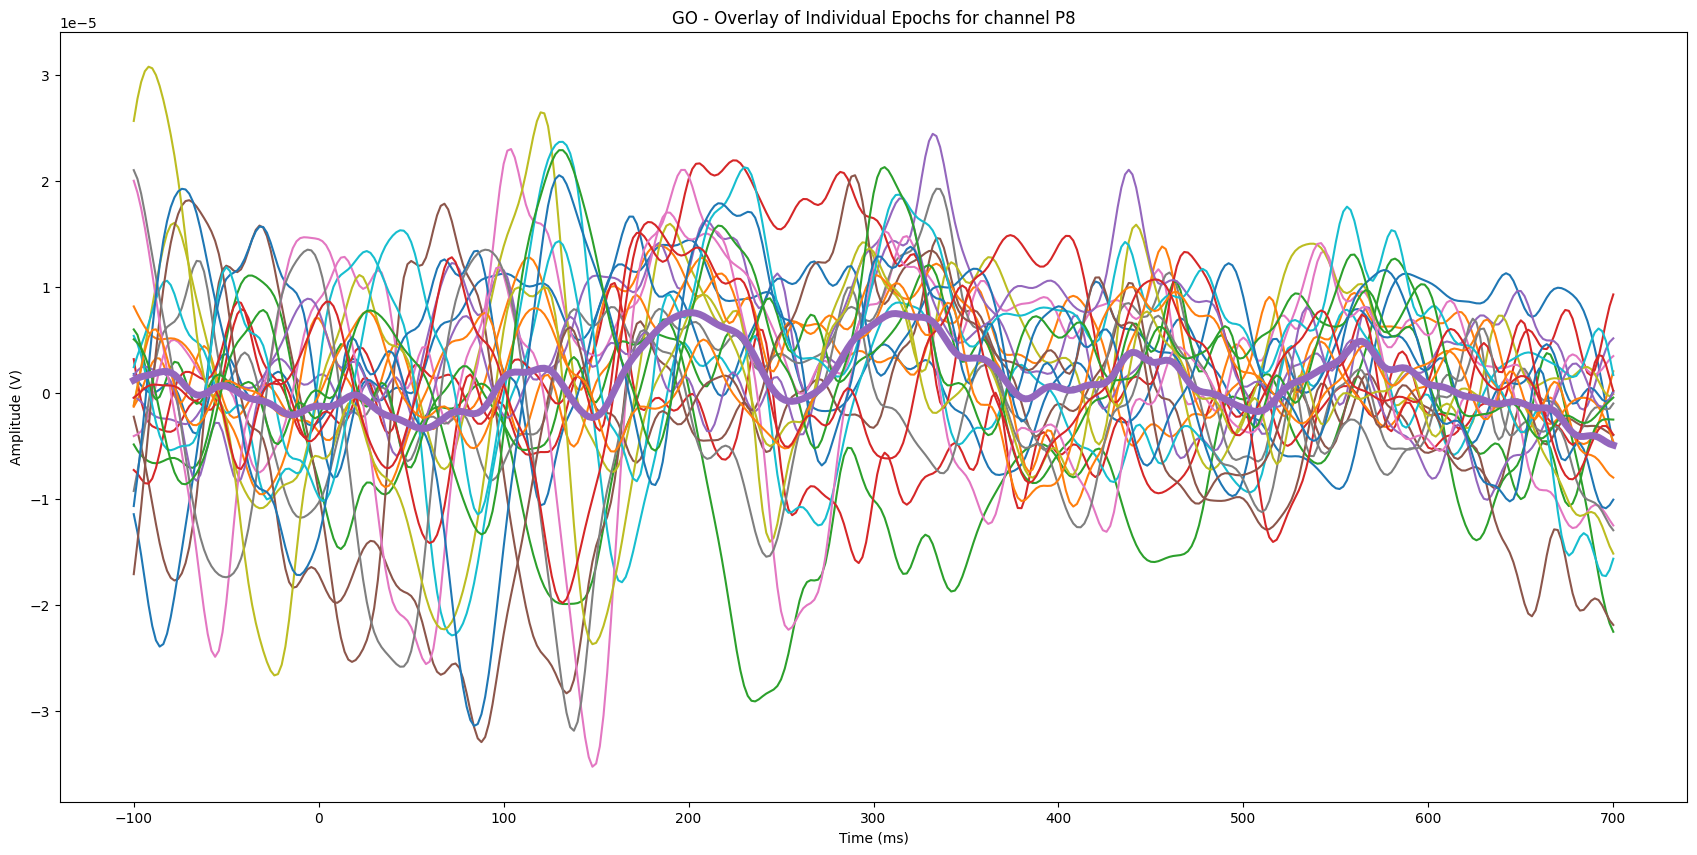

Need more than one channel to make topography for eeg. Disabling interactivity.


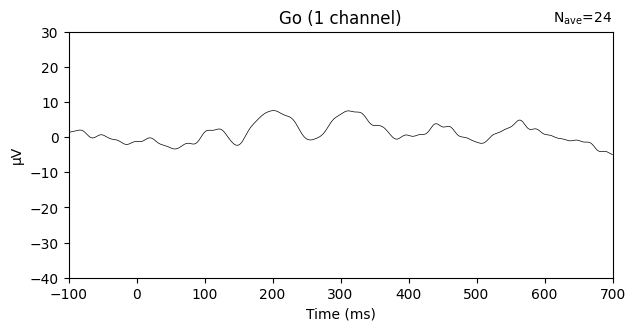

Need more than one channel to make topography for eeg. Disabling interactivity.


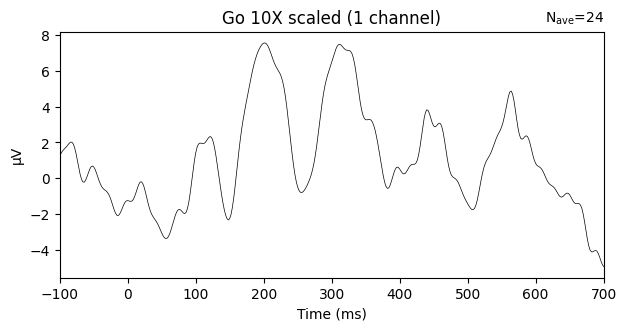

In [18]:
nogo_data = nogo.get_data()
go_data = go.get_data()

# Convert to msec
times = epochs.times *1000 # For each epoch -- Sampling frequency (500 samples/sec) * duration of each epoch (800 msec) 
# TODO: Why times is 401 and not 400 ? Inclusive of -0.1 and 0.7 or exlcusive of what

for channel_index, channel_name in enumerate(channel_names[:32]):
    
    plt.figure(figsize=(21, 10))
    for ind_epoch, epoch in enumerate(epochs):
        # print(type(epochs[ind_epoch]), type(epoch)) # <class 'mne.epochs.Epochs'> <class 'numpy.ndarray'> 32X401
        if next(iter(list(epochs[ind_epoch].event_id.values()))) == 1:
            plt.plot(times, epoch[channel_index], label=f'Epoch {ind_epoch}')
    plt.plot(times, nogo_data[channel_index], linewidth='5')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (V)')
    plt.title(f'NOGO - Overlay of Individual Epochs for channel {channel_name}')
    plt.show()
    nogo.plot(picks=['P8'], titles='Nogo', ylim = dict(eeg=[-5e1, 4e1]), time_unit = 'ms')
    nogo.plot(picks=['P8'], titles='Nogo 10X scaled',  time_unit = 'ms')

    plt.figure(figsize=(21, 10))
    for ind_epoch, epoch in enumerate(epochs):
        # print(type(epochs[ind_epoch]), type(epoch)) # <class 'mne.epochs.Epochs'> <class 'numpy.ndarray'> 32X401
        if next(iter(list(epochs[ind_epoch].event_id.values()))) == 2:
            plt.plot(times, epoch[channel_index], label=f'Epoch {ind_epoch+1}')
    plt.plot(times, go_data[channel_index], linewidth='5')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (V)')
    plt.title(f'GO - Overlay of Individual Epochs for channel {channel_name}')
    plt.show()
    go.plot(picks=['P8'], titles='Go', ylim = dict(eeg=[-4e1, 3e1]),  time_unit = 'ms')
    go.plot(picks=['P8'], titles='Go 10X scaled',  time_unit = 'ms')
    break


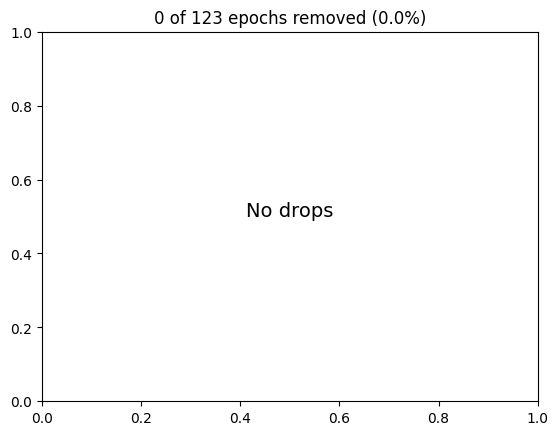

In [19]:
# Plot dropped epochs
epochs.plot_drop_log()

6. Artifact Rejection (EOG/ECG) using ICA

In [20]:
# import numpy as np
# from sklearn.decomposition import FastICA
# # mne.ICA not compatible with python 3+ 

# epochs_data_2d = epochs.get_data().reshape(len(epochs), -1)

# n_components = 3 # TODO: Find optimal number of components later
# ica = FastICA(n_components=n_components, scalingsrandom_state=97, max_iter=100)
# ica_result = ica.fit_transform(epochs_data_2d)

In [21]:
# plt.figure(figsize=(15, 10))

# for i in range(n_components):
#     plt.subplot(5, 7, i + 1) 
#     plt.plot(ica_result[:, i])
#     plt.title('Component {}'.format(i + 1))

# plt.tight_layout()
# plt.show()


7. Averaging

This reduces noise and enhances signal to noise ratio

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


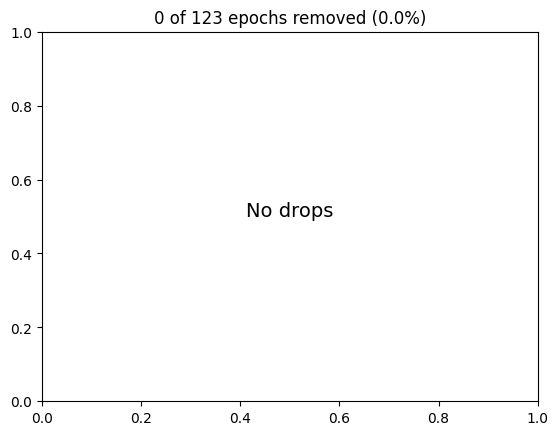

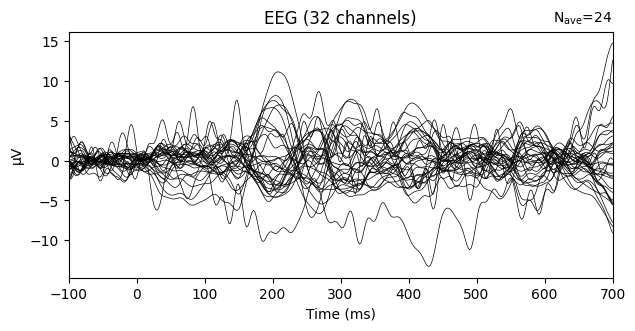

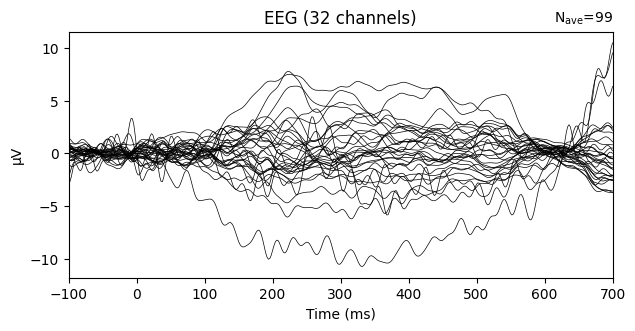

In [22]:
nogo = epochs['1'].average() # average() creates an evoked object - computed average over all epochs of type 1
go = epochs['2'].average()
# discarded = epochs['3'].average()
evokeds = dict(go=go, nogo=nogo)
fig = go.plot(time_unit='ms')
fig.savefig(f'MNE-graphs/go-nogo/go-plot-32channels.png')
fig = nogo.plot(time_unit='ms')
fig.savefig(f'MNE-graphs/go-nogo/nogo-plot-32channels.png')

In [23]:
# fig = mne.viz.plot_compare_evokeds(evokeds, combine="mean", time_unit='ms')
# fig[0].savefig(f'MNE-graphs/go-nogo/all-channels-averaged.png')

C:\Users\vishw\AppData\Local\Temp\ipykernel_6932\3737715463.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=[0, 80, 120], time_unit='ms')


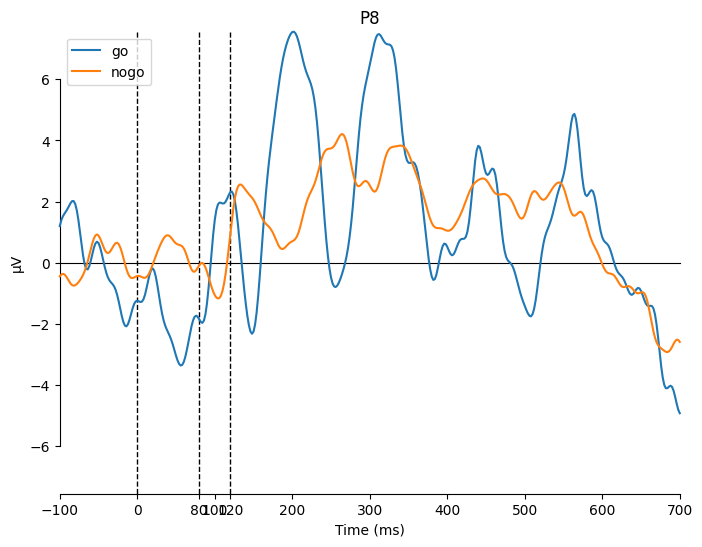

In [24]:
for channel_name in channel_names[:32]:
    # TODO: cross check what combine is !!!! it should be combining all epochs for 1 channel not more than 1 channels together
    fig = mne.viz.plot_compare_evokeds(evokeds, picks=channel_name, vlines=[0, 80, 120], time_unit='ms')
    fig[0].savefig(f'MNE-graphs/go-nogo/{channel_name}.png')

    # fig, ax = plt.subplots()
    # nogo.plot(picks=channel_name, axes=ax, show=False)
    # go.plot(picks=channel_name, axes=ax, show=False)

    # ax.set_title('ERP for ' + channel_name)
    # ax.set_xlabel('Time (s)')
    # ax.set_ylabel('Amplitude (uV)')
    # ax.legend()

    # plt.show()
    break

In [25]:
# GFP plot - # TODO: Use ?
# for evk in (nogo, go):
#     evk.plot(gfp=True, scalings={'eeg': 1e5}, spatial_colors=True)

ERP Analysis
                  

P100 – 80-120 msec after stimulus presentation, Visual processing, positive deflection 
N100 – 80-120 msec after stimulus presentation, Sensory processing, negative deflection 
P200 and N200 – 150-250 msec after stimulus onset, perceptual and cognitive processing
P300 and N300 – cognitive and attention processes, oddball paradigms when unexpected stimulus is present
N400 – 400 msec after stimulus presentation, semantic processing, language comprehension tasks 
P600 – 600 msec post stimulus, language processing, syntactic violations, sentence comprehension
MMN – Mismatch negativity, negative waveform, at around 150-200 msec, brains detection of unexpected or deviant stimuli, auditory processing ad cognitive mismatch

In [26]:
# import pandas as pd

# folder_path = 'E:/IITD/Depression-IITD/Depression-Sample-dataset-AIIMS/'
# sham_or_active = 'Active/' # Active
# patient = 'Preeti singh/'
# pre_post_intervention = 'intervention/'
# directory = folder_path + sham_or_active + patient + pre_post_intervention
# file_path = directory + '20230718203907_Preeti singh_22.08.23_01_STIM.easy'

# df = pd.read_csv(file_path, sep='\t')
# x = df.values[:, -2]

# res=[]
# for i in x:
#     if i!=0:
#         res.append(i)

# print(res)

# transposed_data=df.T

# # Create a MNE-Python info object and specifying sampling rate of data
# ch_names = df.columns.tolist()[:-5]
# ch_types = ['eeg' for i in range(32)]
# info = mne.create_info(ch_names=ch_names,ch_types=ch_types, sfreq=500)

# # Create a Raw object from the DataFrame
# raw = mne.io.RawArray(transposed_data.values[:-5,:], info)

# # Bandpass butterworth filter added
# # Cutoffs at 0.01, 45.00 Hz: -6.02, -6.02 dB
# # Applied only in currently plot
# fig = raw.plot(n_channels=32, 
# lowpass=45, 
# highpass=0.01,
# scalings={'eeg': 1e6} 
# )

AO - triggers --- ERP related
GNG - triggers --- ERP related 
Eye open/eye close - No triggers
Stim - No triggers
